In [14]:
from ellipse import LsqEllipse
import numpy as np
import pandas as pd
from tqdm import tqdm
import pdb
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.widgets import Button
import os
import debugpy
debugpy.breakpoint()

### Convert DLC results to input for AllenGazeMapper

1. Transform x coordinates in DLC because of mirror. And Y coordinates because camera is upside down (pupil parameters). 
2. Get pupil parameters (centerX, centery, height, phi, width)
3. Get eye parameters in DLC system of coordinates (centerX, centery, height, phi, width)
4. Get Corneal reflection (CR) parameters (centerX, centery, height, phi, width)
5. Get eye radius.
6. Get cm per pixel (measure eyelid opener)



1. Transform x coordinates in DLC because of mirror. And Y coordinates because camera is upside down (pupil parameters). 


In [15]:
Data = pd.read_excel(r'\\sil3\data\Large_scale_mapping_NP\Experiment_Excel.xlsx')
Data

,Animal_ID,Species,Experiment_date,Base_path,Exp_name,Insertion,Digital_channel,Diode_channel,Camera_bit,Sync_bit,...,Remove_Spk_duplicates,Manual_curation,Histology,ResponseU,Matlab3Dcoor,Screen_Coor_XYZ,Eye_Coor_XYZ,Camera_Coor_XYZ,DLC_analysis,Phy_goodN
0,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,1,16,0,7,0,...,yes,no,"Slices, photos","1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 17, 20, 22, ...","39.74, 49, -21.44",NaN,NaN,NaN,NaN,NaN
1,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,2,16,0,7,0,...,yes,no,"Slices, photos","2,23,25,28,20,22,25,28,29,32,34,36,37,38,39,40","41.72, 53.4,- 20.94",NaN,NaN,NaN,NaN,NaN
2,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,3,16,0,7,0,...,yes,no,"Slices, photos","3,7,10,14,15,17,18,19,20,26,33,46,50","42.8, 48.82, -22.05",NaN,NaN,NaN,NaN,NaN
3,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,4,16,0,7,0,...,yes,no,"Slices, photos","5,8,13","36.6, 49.9, -21.4",NaN,NaN,NaN,NaN,NaN
4,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,5,16,0,7,0,...,yes,no,"Slices, photos","35,89","41.85, 59.2, -21,8",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,PV132,P. vitticeps,4_5_25,\\sil3\data\Large_scale_mapping_NP\lizards\PV132,PV132_Experiment_4_5_25,5,2,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,PV132,P. vitticeps,4_5_25,\\sil3\data\Large_scale_mapping_NP\lizards\PV132,PV132_Experiment_4_5_25,6,2,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,PV132,P. vitticeps,4_5_25,\\sil3\data\Large_scale_mapping_NP\lizards\PV132,PV132_Experiment_4_5_25,7,2,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,PV132,P. vitticeps,4_5_25,\\sil3\data\Large_scale_mapping_NP\lizards\PV132,PV132_Experiment_4_5_25,8,2,0,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#Ellipse fitting function
def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
    # import the dataframe and convert it to floats
    #data = df.iloc[:100]
    data = dlc_video_analysis_csv.iloc[1:].apply(pd.to_numeric)

    
    # sort the pupil elements to dfs: x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
    
    # get X coords
    pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]
    
    # flip the data around the midpoint of the x-axis (shooting the eye through a camera flips right and left)
    pupil_xs = pupil_xs_before_flip #320 * 2 - pupil_xs_before_flip
    
    # get Y coords (no need to flip as opencv conventions already start with origin at top left of frame
    # and so, positive Y is maintained as up in a flipped image as we have)
    pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
    pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]
    
    # rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]
    
    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320 * 2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2, len(edge_elements), 3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns, edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns, edge_xs.columns)))
    # e = edge_ps < uncertainty_thr
    
    # work row by row to figure out the ellipses
    ellipses = []
    goodFrames = []
    Xs = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm(range(1, len(data) - 1)):
        # first, take all the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values, y_values]
    
        # now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]

        #pdb.set_trace()
    
        # if there are enough rows for a fit, make an ellipse
        Xs.append(X)
        if X.shape[0] > 5:
            #pdb.set_trace()
            goodFrames.append(row)
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x, center_y, width, height, phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])
            
    
    ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    
    
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a * b * math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    #ellipse_df['rostral_edge'] = rostral_edge_ls
    #ellipse_df['caudal_edge'] = caudal_edge_ls
    
    print(f'\n ellipses calculation complete')
    return ellipse_df, Xs, goodFrames

In [ ]:
##Invert y axis of video

for ex in np.arange(70,71): #Select experiments recorded through mirror
    print(ex)

    #shuffle = 'shuffle4'
    #directory = os.path.join(Data['Base_path'][ex],Data['Exp_name'][ex],"Insertion"+str(Data['Insertion'][ex]),"Processed_Video")
    directory = Data['Eye_video_dir'][ex]
    all_files = os.listdir(directory)
    specific_files = [file for file in all_files if file.endswith('.csv') and 'shuffle' in file and 'thr' not in file 
                      and "_"+str(Data['Insertion'][ex])+"_" in file]

    if any('inverted' not in item.lower() for item in specific_files):
        if any('Jitter' in item for item in specific_files):
            s_file = [file for file in specific_files if  'Jitter' in file]
        else:
            s_file = specific_files #[file for file in specific_files if  'filtered' in file]  
    else:
        s_file = specific_files
    
    print(s_file)
    dlc_video_analysis_path =  os.path.join(directory,str(s_file[0]))
    dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path, header=[0, 1],skiprows=1)

    frame_width = 728   # replace with your video width
    frame_height = 544  # replace with your video height

    # Method 1: Invert all coordinates at once
    # Create a copy to work with
    df_inverted = dlc_video_analysis_csv.copy()

    # Get all column names that contain 'x' or 'y'
    for col in dlc_video_analysis_csv.columns[1:]:
         # Multi-level column structure
        bodypart, coordinate = col
        
        if coordinate == 'x':
            # Invert X coordinates (mirror flip)
            df_inverted[col] = dlc_video_analysis_csv[col]#df_inverted[col] = frame_width - dlc_video_analysis_csv[col] #It seems that x coordinates are correct
            
        elif coordinate == 'y':
            # Invert Y coordinates (upside down flip)
            df_inverted[col] = frame_height - dlc_video_analysis_csv[col]
    
    df_inverted.to_csv(dlc_video_analysis_path.replace('.csv','')+'_inverted.csv')


70
['PV132_8_Camera1_20250507-214316DLC_Resnet50_IR_Eye_movementsApr29shuffle1_snapshot_200.csv', 'PV132_8_Camera1_20250507-214316DLC_Resnet50_IR_Eye_movementsApr29shuffle1_snapshot_200_inverted.csv']


In [42]:
s_file[0]


'PV132_8_Camera1_20250507-214316DLC_Resnet50_IR_Eye_movementsApr29shuffle1_snapshot_200.csv'

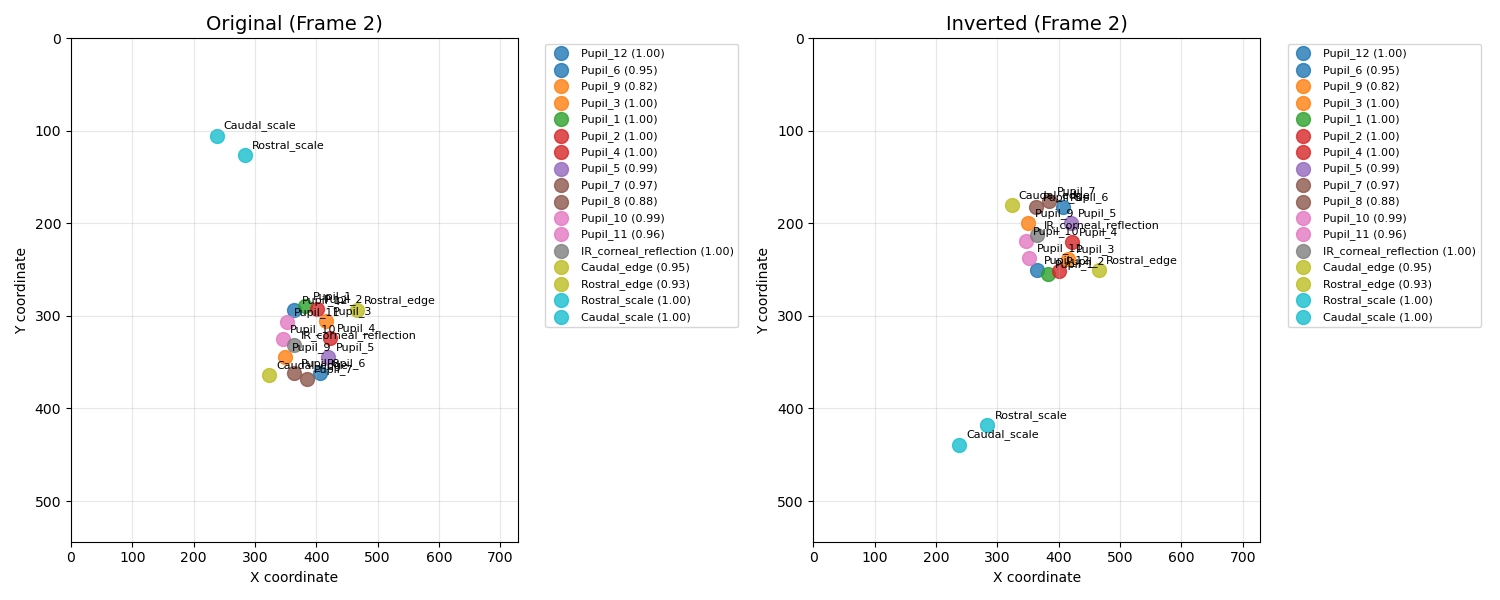

In [43]:
plot_dlc_comparison(dlc_video_analysis_csv, df_inverted, frame_num=2)

In [19]:
def plot_dlc_comparison(df_orig, df_inv, frame_num=0, confidence_threshold=0.5):
    """
    Plot original vs inverted DeepLabCut results for a specific frame
    
    Parameters:
    df_orig: Original DataFrame
    df_inv: Inverted DataFrame  
    frame_num: Frame number to plot (default: 0)
    confidence_threshold: Minimum confidence to plot point (default: 0.5)
    """
    
    # Get bodyparts (skip first column if it's not a bodypart)
    bodyparts = df_orig.columns.get_level_values(0).unique()
    if 'bodyparts' in bodyparts or 'frame' in bodyparts:
        bodyparts = bodyparts[1:]  # Skip first column
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Define colors for each bodypart
    colors = plt.cm.tab10(np.linspace(0, 1, len(bodyparts)))
    
    # Plot original data
    ax1.set_title(f'Original (Frame {frame_num})', fontsize=14)
    ax1.set_xlim(0, frame_width)
    ax1.set_ylim(0, frame_height)
    ax1.invert_yaxis()  # Invert y-axis to match image coordinates
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('X coordinate')
    ax1.set_ylabel('Y coordinate')
    
    # Plot inverted data
    ax2.set_title(f'Inverted (Frame {frame_num})', fontsize=14)
    ax2.set_xlim(0, frame_width)
    ax2.set_ylim(0, frame_height)
    ax2.invert_yaxis()  # Invert y-axis to match image coordinates
    ax2.grid(True, alpha=0.3)
    ax2.set_xlabel('X coordinate')
    ax2.set_ylabel('Y coordinate')
    
    # Plot each bodypart
    for i, bodypart in enumerate(bodyparts):
        try:
            # Get coordinates and confidence for original data
            x_orig = df_orig.iloc[frame_num][(bodypart, 'x')]
            y_orig = df_orig.iloc[frame_num][(bodypart, 'y')]
            conf_orig = df_orig.iloc[frame_num][(bodypart, 'likelihood')]
            
            # Get coordinates and confidence for inverted data
            x_inv = df_inv.iloc[frame_num][(bodypart, 'x')]
            y_inv = df_inv.iloc[frame_num][(bodypart, 'y')]
            conf_inv = df_inv.iloc[frame_num][(bodypart, 'likelihood')]
            
            # Plot only if confidence is above threshold
            if conf_orig >= confidence_threshold:
                ax1.scatter(x_orig, y_orig, c=[colors[i]], s=100, 
                           label=f'{bodypart} ({conf_orig:.2f})', alpha=0.8)
                ax1.annotate(bodypart, (x_orig, y_orig), xytext=(5, 5), 
                           textcoords='offset points', fontsize=8)
            
            if conf_inv >= confidence_threshold:
                ax2.scatter(x_inv, y_inv, c=[colors[i]], s=100, 
                           label=f'{bodypart} ({conf_inv:.2f})', alpha=0.8)
                ax2.annotate(bodypart, (x_inv, y_inv), xytext=(5, 5), 
                           textcoords='offset points', fontsize=8)
                
        except KeyError as e:
            print(f"Could not plot {bodypart}: {e}")
    
    # Add legends
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.show()

2. Get pupil parameters (centerX, centery, height, phi, width)

In [44]:
for ex in np.arange(70,71): #Select experiment in rows 2
    print(ex)

    shuffle = 'shuffle1'
    #directory = os.path.join(Data['Base_path'][ex],Data['Exp_name'][ex],"Insertion"+str(Data['Insertion'][ex]),"Processed_Video")
    directory = Data['Eye_video_dir'][ex]
    all_files = os.listdir(directory)
    specific_files = [file for file in all_files if file.endswith('.csv') and shuffle in file and 'thr' not in file 
                      and "_"+str(Data['Insertion'][ex])+"_" in file]
    
    uncertainty_thr = 0.8

    if any('inverted' in item.lower() for item in specific_files):
        s_file = [file for file in specific_files if  'inverted' in file] 
        print(s_file)
        dlc_video_analysis_path =  os.path.join(directory,str(s_file[0]))
        dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path) 
    else:
        s_file = specific_files
        print(s_file)
        dlc_video_analysis_path =  os.path.join(directory,str(s_file[0]))
        dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)
    

    #Run ellipse fitting
    [ellipse_df,Xs,goodFrames] = eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr)

    print(ellipse_df.shape)
    print(f'Total frames {Data['Animal_ID'][ex]+"_"+str(Data['Insertion'][ex])} = {dlc_video_analysis_csv.shape[0]}')
    print(f'Good frames {Data['Animal_ID'][ex]+"_"+str(Data['Insertion'][ex])} = {len(goodFrames)}')
    print(f'Percentage of Good frames {Data['Animal_ID'][ex]+"_"+str(Data['Insertion'][ex])} = {len(goodFrames)/dlc_video_analysis_csv.shape[0]}')
    #Save results
    ## Save results:
    ellipse_df.to_csv(os.path.join(directory,str(s_file[0].removesuffix(".csv"))+str(f'_Eye_ellipse_thr_{uncertainty_thr}.csv')), index=False)
    dfGF = pd.DataFrame(goodFrames, columns=['Values'])    
    dfGF.to_csv(os.path.join(directory,str(s_file[0].removesuffix(".csv"))+str(f'_good_frames_thr_{uncertainty_thr}.csv')), index=False)




70
['PV132_8_Camera1_20250507-214316DLC_Resnet50_IR_Eye_movementsApr29shuffle1_snapshot_200_inverted.csv']


C:\Users\MarkS9\AppData\Local\Temp\ipykernel_13496\1487791412.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path)
100%|██████████| 582433/582433 [01:10<00:00, 8312.83it/s]



 ellipses calculation complete
(582433, 6)
Total frames PV132_8 = 582436
Good frames PV132_8 = 582327
Percentage of Good frames PV132_8 = 0.9998128549746238


<bound method DataFrame.isna of           center_x    center_y      width     height       phi  ellipse_size
0       384.259129  215.504523  38.431549  39.678855  0.214412   4790.677071
1       384.259134  215.504409  38.431719  39.679831  0.214462   4790.816011
2       384.262871  215.501062  38.433434  39.678060  0.212636   4790.816055
3       384.262287  215.501807  38.432724  39.679013  0.212338   4790.842543
4       384.262287  215.501807  38.432724  39.679013  0.212338   4790.842543
...            ...         ...        ...        ...       ...           ...
582428  378.417102  210.349369  41.346864  43.650860  0.271265   5670.028568
582429  378.406183  210.335732  41.359423  43.655332  0.264072   5672.331902
582430  378.416623  210.349240  41.346530  43.649852  0.271005   5669.851902
582431  378.407739  210.297498  41.362325  43.695819  0.259834   5677.991070
582432  378.409648  210.358092  41.348095  43.639474  0.271612   5668.718401

[582433 rows x 6 columns]>

3. Get eye parameters in DLC system of coordinates (centerX, centery, height, phi, width)
4. Get Corneal reflection (CR) parameters (centerX, centery, height, phi, width)


<>:86: SyntaxWarning: invalid escape sequence '\L'
<>:86: SyntaxWarning: invalid escape sequence '\L'
C:\Users\MarkS9\AppData\Local\Temp\ipykernel_13496\334922028.py:86: SyntaxWarning: invalid escape sequence '\L'
  video_path = 'W:\Large_scale_mapping_NP\lizards\PV132\PV132_Experiment_4_5_25\Videos\PV132_8_Camera1_20250507-214316.mp4'  # Replace with your path


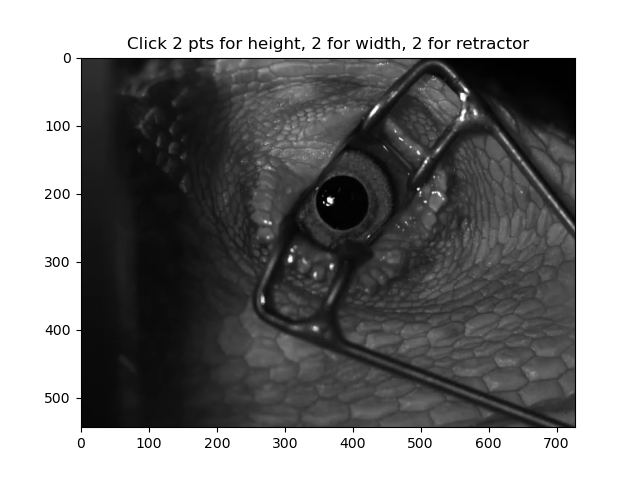


### ✅ Eye + Retractor Parameters
- **eye_height** = `128.05` px  
- **eye_width** = `170.74` px  
- **eye_center** = `(381.16, 203.94)`  
- **eye_phi** = `0.610` radians (34.93°)  
- **retractor_length** = `106.16` px
        

In [10]:
%matplotlib widget

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Global state
lines = []
eye_height = None
eye_width = None
eye_center = None
eye_phi = None
retractor_length = None

def onclick(event):
    if event.inaxes:
        lines.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, 'ro')
        fig.canvas.draw()

        if len(lines) == 6:
            fig.canvas.mpl_disconnect(cid)
            process_lines()

def process_lines():
    global eye_height, eye_width, eye_center, eye_phi, retractor_length

    try:
        # First 2 points: vertical line
        x1, y1 = lines[0]
        x2, y2 = lines[1]
        eye_height = abs(y2 - y1)

        # Next 2 points: horizontal line
        x3, y3 = lines[2]
        x4, y4 = lines[3]
        eye_width = abs(x4 - x3)

        # Eye center (horizontal midpoint, vertical midpoint)
        eye_center_x = (x3 + x4) / 2
        eye_center_y = (y1 + y2) / 2
        eye_center = (eye_center_x, eye_center_y)

        # Eye phi (angle of horizontal line)
        dx = x4 - x3
        dy = y4 - y3
        eye_phi = np.arctan2(dy, dx)

        # Last 2 points: retractor length (Euclidean distance)
        x5, y5 = lines[4]
        x6, y6 = lines[5]
        retractor_length = np.sqrt((x6 - x5)**2 + (y6 - y5)**2)

        # Output in notebook
        display(Markdown(f"""
### ✅ Eye + Retractor Parameters
- **eye_height** = `{eye_height:.2f}` px  
- **eye_width** = `{eye_width:.2f}` px  
- **eye_center** = `({eye_center_x:.2f}, {eye_center_y:.2f})`  
- **eye_phi** = `{eye_phi:.3f}` radians ({np.degrees(eye_phi):.2f}°)  
- **retractor_length** = `{retractor_length:.2f}` px
        """))

        # Optional text overlay
        ax.text(10, 20, f"Height: {eye_height:.1f}", color='yellow', fontsize=12)
        ax.text(10, 40, f"Width: {eye_width:.1f}", color='yellow', fontsize=12)
        ax.text(10, 60, f"Retractor: {retractor_length:.1f}", color='yellow', fontsize=12)
        fig.canvas.draw()

    except Exception as e:
        display(Markdown(f"**Error in processing:** {e}"))

def get_frame_from_video(video_path, frame_number=0):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise ValueError("Could not read frame.")

    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Run the GUI ---
video_path = 'W:\Large_scale_mapping_NP\lizards\PV132\PV132_Experiment_4_5_25\Videos\PV132_8_Camera1_20250507-214316.mp4'  # Replace with your path
frame_number = 100             # Pick frame number

img = get_frame_from_video(video_path, frame_number)
img = cv2.flip(img, 0)  # Flip both x and y (equivalent to mirror + upside down)

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title("Click 2 pts for height, 2 for width, 2 for retractor")
cid = fig.canvas.mpl_connect('button_press_event', onclick)


plt.show()


5. Get eye radius.
6. Get cm per pixel (measure eyelid opener)

In [26]:
RetractorCM = 0.3
CMperPix = RetractorCM/retractor_length
CMperPix

0.0028259803884791083

In [28]:
#hnck rows that contain nans and look at csv\
nan_rows = ellipse_df[ellipse_df.isna().any(axis=1)]
print(nan_rows.index)

Index([ 31122,  31123,  31124,  31125,  31126,  31127,  31128,  31129,  31130,
        31131,
       ...
       545182, 545183, 545184, 545185, 545186, 545187, 545188, 545189, 545190,
       545191],
      dtype='int64', length=106)


In [51]:
data = dlc_video_analysis_csv.iloc[1:].apply(pd.to_numeric)
row = data.loc[7458]
count = row[[col for col in row.index if col.endswith('.2') and 'Pupil' in col]].gt(0.5).sum()
count


6

In [69]:
filtered_cols = [col for col in data.columns if col.endswith('.2') and 'Pupil' in col]
counts = (data[filtered_cols] > 0.5).sum(axis=1)
sum(counts > 3)


226757

In [ ]:
   # import the dataframe and convert it to floats
#data = df.iloc[:100]
data = dlc_video_analysis_csv.iloc[1:].apply(pd.to_numeric)


# sort the pupil elements to dfs: x and y, with p as probability
pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])

# get X coords
pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]

# flip the data around the midpoint of the x-axis (shooting the eye through a camera flips right and left)
pupil_xs = pupil_xs_before_flip #320 * 2 - pupil_xs_before_flip

# get Y coords (no need to flip as opencv conventions already start with origin at top left of frame
# and so, positive Y is maintained as up in a flipped image as we have)
pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]

# rename dataframes for masking with p values of bad points:
pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
good_points = pupil_ps > uncertainty_thr
pupil_xs = pupil_xs[good_points]
pupil_ys = pupil_ys[good_points]

# Do the same for the edges
edge_elements = np.array([x for x in data.columns if 'edge' in x])
edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
edge_xs = 320 * 2 - edge_xs_before_flip
edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
edge_ps = data[edge_elements[np.arange(2, len(edge_elements), 3)]]
edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns, edge_xs.columns)))
edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns, edge_xs.columns)))
# e = edge_ps < uncertainty_thr

# work row by row to figure out the ellipses
ellipses = []
goodFrames = []
Xs = []
caudal_edge_ls = []
rostral_edge_ls = []
for row in tqdm(range(1, len(data) - 1)):
    # first, take all the values, and concatenate them into an X array
    x_values = pupil_xs.loc[row].values
    y_values = pupil_ys.loc[row].values
    X = np.c_[x_values, y_values]

    # now, remove nan values, and check if there are enough points to make the ellipse
    X = X[~ np.isnan(X).any(axis=1)]

    #pdb.set_trace()

    # if there are enough rows for a fit, make an ellipse
    Xs.append(X)
    if X.shape[0] > 5:
        #pdb.set_trace()
        goodFrames.append(row)
        el = LsqEllipse().fit(X)
        center, width, height, phi = el.as_parameters()
        center_x = center[0]
        center_y = center[1]
        ellipses.append([center_x, center_y, width, height, phi])
    else:
        ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])

,bodyparts,Pupil_12,Pupil_12.1,Pupil_12.2,Pupil_6,Pupil_6.1,Pupil_6.2,Pupil_9,Pupil_9.1,Pupil_9.2,...,Caudal_edge.2,Rostral_edge,Rostral_edge.1,Rostral_edge.2,Rostral_scale,Rostral_scale.1,Rostral_scale.2,Caudal_scale,Caudal_scale.1,Caudal_scale.2
1,0,379.45508,318.68740,0.406004,441.58460,375.61243,0.498091,371.47270,359.60663,0.261229,...,0.308314,511.10010,298.31920,0.177539,493.52646,221.69113,0.388461,452.66678,222.38852,0.371449
2,1,379.45508,318.68740,0.406004,441.58460,375.61243,0.498091,371.47270,359.60663,0.261229,...,0.308314,511.10010,298.31920,0.177539,493.52646,221.69113,0.388461,452.66678,222.38852,0.371449
3,2,379.46558,318.68076,0.405988,441.61728,375.58493,0.499073,371.49160,359.60236,0.259009,...,0.308442,511.09610,298.31958,0.177553,493.52716,221.68924,0.388834,452.66806,222.38622,0.371463
4,3,379.46558,318.68076,0.405988,441.61728,375.58493,0.499073,371.49160,359.60236,0.259009,...,0.308442,511.09610,298.31958,0.177553,493.52716,221.68924,0.388834,452.66806,222.38622,0.371463
5,4,379.46558,318.68076,0.405988,441.61728,375.58493,0.499073,371.49160,359.60236,0.259009,...,0.308442,511.09610,298.31958,0.177553,493.52716,221.68924,0.388834,452.66806,222.38622,0.371463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238642,238641,370.88846,332.20184,0.440044,426.59195,385.86667,0.416535,365.75380,372.06516,0.279168,...,0.185800,608.74360,295.56168,0.321019,395.52618,311.12534,0.071852,298.57858,337.84274,0.116734
238643,238642,370.88925,332.20123,0.440238,426.59192,385.86820,0.416495,365.75366,372.06488,0.279282,...,0.185816,608.74400,295.56260,0.321037,395.52850,311.12418,0.071886,298.57925,337.84015,0.116530
238644,238643,370.95938,332.19653,0.444577,426.59323,385.86300,0.416365,365.76407,372.07318,0.280515,...,0.185726,608.86115,295.50674,0.326253,395.51483,311.16824,0.071878,298.58063,337.84027,0.116659
238645,238644,370.95987,332.19806,0.444393,426.57312,385.88107,0.416848,365.76337,372.07397,0.280484,...,0.185628,608.86130,295.50540,0.326265,395.51413,311.16520,0.071908,298.57860,337.83980,0.116678


In [41]:
#dlc_video_analysis_path1 =  r"C:\Users\MarkS9\Desktop\HeadFixedEyeTrack2-Simon-2024-10-02\EyeTracking3-Simon-2024-10-03\videos\PV35_Insertion4_Camera1_20240821-115142DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200.csv"

#dlc_video_analysis_path =  r"C:\Users\MarkS9\Desktop\HeadFixedEyeTrack2-Simon-2024-10-02\EyeTracking3-Simon-2024-10-03\videos\pv35_Insertion2_Camera1_20240819-123015DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200.csv"
#dlc_video_analysis_path = r"C:\Users\MarkS9\Desktop\HeadFixedEyeTrack2-Simon-2024-10-02\EyeTracking3-Simon-2024-10-03\videos\pv35_Insertion3_Camera1_20240819-152541DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200.csv"
#dlc_video_analysis_path = r"W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\EnhancedVids\EnhancedContrast-SA8_7_11_24_3_Camera1_20241111-162540croppedDLC_Resnet50_EyeTracking3Oct3shuffle2_snapshot_200.csv"
#dlc_video_analysis_path = r"W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\EnhancedVids\SA8_insertion5_Camera1_20241126-160054DLC_Resnet50_EyeTracking3Oct3shuffle2_snapshot_200_filtered.csv"
dlc_video_analysis_path = r"W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\EnhancedVids\EnhancedContrast-SA8_7_11_24_1_Camera1_20241107-143003croppedDLC_Resnet50_EyeTracking3Oct3shuffle2_snapshot_200.csv"
uncertainty_thr = 0.80
dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)
#dlc_video_analysis_csv1 = pd.read_csv(dlc_video_analysis_path1)
#dlc_video_analysis_csv.columns = dlc_video_analysis_csv.iloc[0]
#dlc_video_analysis_csv = dlc_video_analysis_csv[1:].reset_index(drop=True)
#dlc_video_analysis_csv1 = pd.read_csv('ExampleDFsimon.csv')

C:\Users\MarkS9\AppData\Local\Temp\ipykernel_10504\4107581291.py:9: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)


In [44]:
uncertainty_thr = 0.8

In [22]:
dlc_video_analysis_csv

,bodyparts,Pupil_12,Pupil_12.1,Pupil_12.2,Pupil_6,Pupil_6.1,Pupil_6.2,Pupil_3,Pupil_3.1,Pupil_3.2,...,Pupil_11.2,Pupil_7,Pupil_7.1,Pupil_7.2,Pupil_5,Pupil_5.1,Pupil_5.2,Pupil_2,Pupil_2.1,Pupil_2.2
0,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,...,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
1,0,293.22665,192.09506,0.17483498,299.76508,246.68791,1.0,327.19644,210.61617,0.31084463,...,0.19807263,287.0406,241.14807,0.89779395,316.5068,245.35686,0.39031398,319.10202,199.70432,0.2185246
2,1,293.22702,192.09653,0.17487614,299.7655,246.69048,1.0,327.1976,210.61717,0.3107848,...,0.19803166,287.04016,241.15065,0.89774346,316.5062,245.35855,0.39037716,319.10312,199.70589,0.21857195
3,2,293.25983,192.08237,0.17436416,299.7552,246.6849,1.0,327.24826,210.68066,0.3069846,...,0.1971627,287.0482,241.14319,0.8976288,316.494,245.36337,0.38705954,319.1899,199.69864,0.21579768
4,3,293.25983,192.08237,0.17436416,299.7552,246.6849,1.0,327.24826,210.68066,0.3069846,...,0.1971627,287.0482,241.14319,0.8976288,316.494,245.36337,0.38705954,319.1899,199.69864,0.21579768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726974,726973,365.97864,195.30435,0.017915,348.26236,210.21904,0.023093,366.93854,198.21358,0.026513,...,0.014536,335.74918,210.87355,0.031646,380.26913,215.17044,0.017081,369.07806,199.50854,0.026405
726975,726974,365.89505,195.25595,0.017526,348.71606,210.08041,0.018532,367.3157,197.94063,0.028105,...,0.014456,336.00244,210.86092,0.031894,380.2719,215.44048,0.017357,369.39423,199.2027,0.026193
726976,726975,365.9707,195.44394,0.017199,348.57172,210.11966,0.01947,367.08154,198.19823,0.025325,...,0.01447,335.93335,210.89561,0.030951,380.14395,215.38844,0.017371,369.14896,199.52084,0.024676
726977,726976,365.9268,195.50587,0.015984,348.38913,210.16019,0.021056,366.95023,198.26367,0.023774,...,0.01382,335.9004,211.01523,0.032027,380.02838,215.26309,0.016637,368.99948,199.6494,0.023857


In [39]:
dlc_video_analysis_csv.columns

Index(['bodyparts', 'Pupil_12', 'Pupil_12.1', 'Pupil_12.2', 'Pupil_6',
       'Pupil_6.1', 'Pupil_6.2', 'Pupil_3', 'Pupil_3.1', 'Pupil_3.2',
       'Pupil_9', 'Pupil_9.1', 'Pupil_9.2', 'Caudal_edge', 'Caudal_edge.1',
       'Caudal_edge.2', 'Rostral_edge', 'Rostral_edge.1', 'Rostral_edge.2',
       'Pupil_1', 'Pupil_1.1', 'Pupil_1.2', 'Pupil_4', 'Pupil_4.1',
       'Pupil_4.2', 'Pupil_8', 'Pupil_8.1', 'Pupil_8.2', 'Pupil_10',
       'Pupil_10.1', 'Pupil_10.2', 'Pupil_11', 'Pupil_11.1', 'Pupil_11.2',
       'Pupil_7', 'Pupil_7.1', 'Pupil_7.2', 'Pupil_5', 'Pupil_5.1',
       'Pupil_5.2', 'Pupil_2', 'Pupil_2.1', 'Pupil_2.2'],
      dtype='object')

In [17]:
#@staticmethod
def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
    # import the dataframe and convert it to floats
    #data = df.iloc[:100]
    data = dlc_video_analysis_csv.iloc[1:].apply(pd.to_numeric)

    
    # sort the pupil elements to dfs: x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
    
    # get X coords
    pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]
    
    # flip the data around the midpoint of the x-axis (shooting the eye through a camera flips right and left)
    pupil_xs = pupil_xs_before_flip #320 * 2 - pupil_xs_before_flip
    
    # get Y coords (no need to flip as opencv conventions already start with origin at top left of frame
    # and so, positive Y is maintained as up in a flipped image as we have)
    pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
    pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]
    
    # rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]
    
    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320 * 2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2, len(edge_elements), 3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns, edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns, edge_xs.columns)))
    # e = edge_ps < uncertainty_thr
    
    # work row by row to figure out the ellipses
    ellipses = []
    goodFrames = []
    Xs = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm(range(1, len(data) - 1)):
        # first, take all the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values, y_values]
    
        # now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]

        #pdb.set_trace()
    
        # if there are enough rows for a fit, make an ellipse
        Xs.append(X)
        if X.shape[0] > 5:
            #pdb.set_trace()
            goodFrames.append(row)
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x, center_y, width, height, phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    
        # caudal_edge = [
        #     float(data['Caudal_edge'][row]),
        #     float(data['Caudal_edge.1'][row])
        # ]
        # rostral_edge = [
        #     float(data['Rostral_edge'][row]),
        #     float(data['Rostral_edge.1'][row])
        # ]
        # caudal_edge_ls.append(caudal_edge)
        # rostral_edge_ls.append(rostral_edge)
    
    ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    
    
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a * b * math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    #ellipse_df['rostral_edge'] = rostral_edge_ls
    #ellipse_df['caudal_edge'] = caudal_edge_ls
    
    print(f'\n ellipses calculation complete')
    return ellipse_df, Xs, goodFrames

In [45]:
[ellipse_df,Xs,goodFrames] = eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr)

100%|█████████████████████████████████████████████████████████████████████| 2015909/2015909 [01:55<00:00, 17445.04it/s]



 ellipses calculation complete


In [46]:
print(ellipse_df.shape)
print(dlc_video_analysis_csv.shape)
print(len(goodFrames))

(2015909, 6)
(2015912, 43)
395751


In [31]:
## Save results:
ellipse_df.to_csv(f'W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\Insertion5\SA8_5_Eye_ellipse_thr_{uncertainty_thr}.csv', index=False)
dfGF = pd.DataFrame(goodFrames, columns=['Values'])
dfGF.to_csv(f'W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\Insertion5\SA8_5_good_frames_thr_{uncertainty_thr}.csv', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
C:\Users\MarkS9\AppData\Local\Temp\ipykernel_10504\4031653399.py:2: SyntaxWarning: invalid escape sequence '\L'
  ellipse_df.to_csv(f'W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\Insertion5\SA8_5_Eye_ellipse_thr_{uncertainty_thr}.csv', index=False)
C:\Users\MarkS9\AppData\Local\Temp\ipykernel_10504\4031653399.py:4: SyntaxWarning: invalid escape sequence '\L'
  dfGF.to_csv(f'W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\Insertion5\SA8_5_good_frames_thr_{uncertainty_thr}.csv', index=False)


AttributeError: 'list' object has no attribute 'shape'

In [45]:
type(goodFrames)

list

In [44]:
f'W:\Large_scale_mapping_NP\lizards\PV35\PV35_Experiment_18_8_24\Insertion2\PV35_2_Eye_ellipse_thr_{uncertainty_thr}.csv'

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\MarkS9\AppData\Local\Temp\ipykernel_22008\2896634138.py:1: SyntaxWarning: invalid escape sequence '\L'
  f'W:\Large_scale_mapping_NP\lizards\PV35\PV35_Experiment_18_8_24\Insertion2\PV35_2_Eye_ellipse_thr_{uncertainty_thr}.csv'


'W:\\Large_scale_mapping_NP\\lizards\\PV35\\PV35_Experiment_18_8_24\\Insertion2\\PV35_2_Eye_ellipse_thr_0.8.csv'

In [42]:
print(len(dlc_video_analysis_csv))
print(len(ellipse_df))
print(len(goodFrames))
print(ellipse_df.isnull().any(axis=1).sum())

710542
710539
710539
0


In [38]:
#613142
len(goodFrames)

613142

(439.564718251, 521.1035749980639, 83.38134793396486, 162.6364814245088)

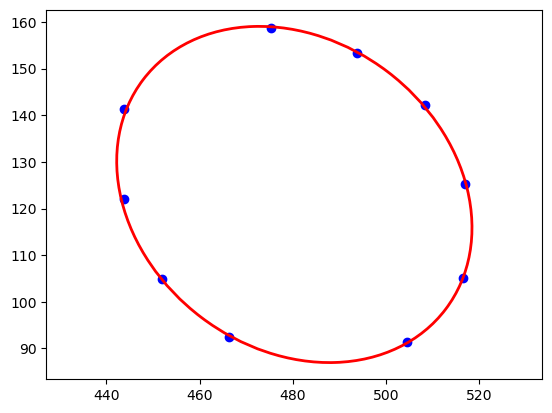

In [67]:
# Create a plot
fig, ax = plt.subplots()

row = 0
# Scatter plot of points
ax.scatter(Xs[row][:,0], Xs[row][:,1], color="blue", label="Points")
ellipse = Ellipse(xy=(ellipse_df.center_x[row], ellipse_df.center_y[row]),width= 2*ellipse_df.width[row], height = 2*ellipse_df.height[row], 
                  angle = np.degrees(ellipse_df.phi[row]), edgecolor="red", facecolor="none", lw=2)
ax.add_patch(ellipse)
plt.axis('equal')




In [37]:
np.degrees(ellipse_df.phi[1])


-37.05784139422994

In [46]:
print(len(Xs))
print(ellipse_df.shape)

705527
(705527, 6)


In [25]:
ellipse_df.to_csv(f'W:\Large_scale_mapping_NP\lizards\PV35\PV35_Experiment_18_8_24\Insertion2\PV35_2_Eye_ellipse_thr_{uncertainty_thr}.csv', index=False)

In [40]:
ellipse_df = pd.read_csv(r'PV35_2.csv')
ellipse_df

,center_x,center_y,width,height,phi,ellipse_size
0,480.334147,123.008915,40.713021,33.056247,-0.649406,4228.017228
1,480.296511,122.970827,40.711358,33.083265,-0.646781,4231.300118
2,480.337608,122.649134,40.839759,33.143213,-0.664699,4252.336673
3,480.336915,122.648994,40.840327,33.142868,-0.664609,4252.351734
4,480.336915,122.648994,40.840327,33.142868,-0.664609,4252.351734
...,...,...,...,...,...,...
705522,497.617510,122.280954,40.867977,30.836083,-0.740371,3959.061210
705523,497.620294,122.281806,40.866137,30.836554,-0.740364,3958.943466
705524,497.484265,122.175140,40.848169,30.877330,-0.732031,3962.435542
705525,497.591312,122.249793,40.876816,30.839999,-0.739898,3960.420340


In [46]:
pathvid = r'C:\Users\MarkS9\Desktop\HeadFixedEyeTrack2-Simon-2024-10-02\EyeTracking3-Simon-2024-10-03\videos\pv35_Insertion2_Camera1_20240819-123015DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200_p60_labeled.mp4'

In [42]:
def play_video_with_ellipses_rotation(ellipse_dataframe,path_to_video=True, xflip=False, transformation_matrix=None, phi_in_radians=False):

    if path_to_video is not False:
        video_path = path_to_video

   # pdb.set_trace()

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.loc[ellipse_dataframe.index == current_frame_num].index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()

In [47]:
play_video_with_ellipses_rotation(ellipse_df,pathvid)

KeyboardInterrupt: 

In [44]:
pathvid

'C:\\Users\\MarkS9\\Desktop\\Videos_trainingDLC\\pv35_Insertion2_Camera1_20240819-123015DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200_p60_labeled.mp4'